<a href="https://colab.research.google.com/github/sivagunturi/mfr_meta/blob/main/Datasetcreation%2Bmask2face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask2Face
This notebook will guide you through all the steps described in this article to build and train your ML model for removing the face mask of the person's face.

In [1]:
!pip install gdown
!pip install opencv-python==4.4.0.44
!pip install tensorflow-addons==0.10.0
!pip install trianglesolver==1.2
!pip uninstall imgaug
!pip install imgaug==0.2.5
!pip install mtcnn
!pip install dotmap

  Using cached opencv_python-4.4.0.44-cp37-cp37m-manylinux2014_x86_64.whl (49.5 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.5.64
    Uninstalling opencv-python-4.5.5.64:
      Successfully uninstalled opencv-python-4.5.5.64
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deepface 0.0.75 requires opencv-python>=4.5.5.64, but you have opencv-python 4.4.0.44 which is incompatible.
Found existing installation: imgaug 0.2.5
Uninstalling imgaug-0.2.5:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/imgaug-0.2.5.dist-info/*
    /usr/local/lib/python3.7/dist-packages/imgaug/*
Proceed (y/n)? y
  Successfully uninstalled imgaug-0.2.5
  Using cached imgaug-0.2.5-py3-none-any.whl


In [2]:
import glob
import os
import random
import re
import shutil
import subprocess
import sys
import tarfile
import zipfile
from distutils.dir_util import copy_tree
from os.path import exists
from pathlib import Path
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab.patches import cv2_imshow
from numpy import load
# !pip install mtcnn pillow dotmap deepface
from PIL import Image
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.svm import SVC
from tensorflow import keras
from tensorflow.keras.preprocessing.image import (array_to_img, img_to_array,
                                                  load_img)
from os.path import exists

In [3]:
tf.test.gpu_device_name()
MFR_REPO_COLAB_PATH='/content/mfr_meta'
MFR_REPO_GIT_PATH = 'https://github.com/sivagunturi/mfr_meta.git'
STRV_REPO_COLAB_PATH = "/content/strv"
STRV_REPO_GIT_PATH = 'https://github.com/sivagunturi/strv.git'
MTF_REPO_COLAB_PATH="/content/MaskTheFace"
MTF_REPO_GIT_PATH="https://github.com/aqeelanwar/MaskTheFace"
MTF_MODEL_NAME =  "model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5"

In [4]:
yorn = input ("Force delete all code directpries (y/n)") 
if(yorn == 'y'):
  os.chdir("/")
  if(os.path.isdir(MFR_REPO_COLAB_PATH) == True):
    shutil.rmtree(MFR_REPO_COLAB_PATH)
  if(os.path.isdir(STRV_REPO_COLAB_PATH) == True):
    shutil.rmtree(STRV_REPO_COLAB_PATH)
  if(os.path.isdir(MTF_REPO_GIT_PATH) == True): 
    shutil.rmtree(MTF_REPO_GIT_PATH)

Force delete all code directpries (y/n)y


In [5]:
def clone_repo_install_dependencies(repo_path, git_path):
  if(os.path.isdir(repo_path) == False):
    os.chdir('/content')
    results = subprocess.run(["git", "clone", git_path], capture_output=True)
    print(results)
    # os.chdir(repo_path)
    # subprocess.run(["pip", "install",'-r', "requirements.txt"], stdout=subprocess.DEVNULL, stderr=subprocess.STDOUT)
    return True
  return False

In [6]:
mfr_install = clone_repo_install_dependencies(MFR_REPO_COLAB_PATH, MFR_REPO_GIT_PATH)
strv_install = clone_repo_install_dependencies(STRV_REPO_COLAB_PATH, STRV_REPO_GIT_PATH)
mtf_install = clone_repo_install_dependencies(MTF_REPO_COLAB_PATH, MTF_REPO_GIT_PATH)
# if(mfr_install or strv_install or mtf_install):
#   os.kill(os.getpid(), 9)

CompletedProcess(args=['git', 'clone', 'https://github.com/sivagunturi/mfr_meta.git'], returncode=0, stdout=b'', stderr=b"Cloning into 'mfr_meta'...\n")
CompletedProcess(args=['git', 'clone', 'https://github.com/sivagunturi/strv.git'], returncode=0, stdout=b'', stderr=b"Cloning into 'strv'...\n")


In [7]:
ls /content/

MaskTheFace/  mfr_meta/  sample_data/  strv/


In [8]:
os.chdir(STRV_REPO_COLAB_PATH)

In [9]:
# Necessary imports
from utils import download_data
from utils.architectures import UNet
from utils.configuration import Configuration
from utils.data_generator import DataGenerator
from utils.model import Mask2FaceModel

In [10]:
# setup HW

# is GPU available
gpu_physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_physical_devices) > 0:
    tf.config.experimental.set_memory_growth(gpu_physical_devices[0], True)

# check HW availability
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.experimental.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


## 1) Preconditions
First we need a dataset of human faces.

In [11]:
def download_from_drive(id, output_file, unzip=False):
  results = subprocess.run(["gdown", "--id", id, "--output", output_file], capture_output=True)
  print(results)
  if(unzip):
    subprocess.run(["unzip", output_file], capture_output=True)
    print(results)

In [12]:
download_from_drive("1egNNyrOv1Xdio8peNla1QDVBSIDu-Fjv", "model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5")
download_from_drive("1iWqF8dWpDPZbciufcUyPuprLfcP4Zs4w", "data.zip", unzip=True)

CompletedProcess(args=['gdown', '--id', '1egNNyrOv1Xdio8peNla1QDVBSIDu-Fjv', '--output', 'model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5'], returncode=0, stdout=b'', stderr=b"/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.\n  category=FutureWarning,\nDownloading...\nFrom: https://drive.google.com/uc?id=1egNNyrOv1Xdio8peNla1QDVBSIDu-Fjv\nTo: /content/strv/model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5\n\r  0%|          | 0.00/643M [00:00<?, ?B/s]\r  3%|\xe2\x96\x8e         | 20.4M/643M [00:00<00:03, 203MB/s]\r  9%|\xe2\x96\x8a         | 55.6M/643M [00:00<00:02, 289MB/s]\r 14%|\xe2\x96\x88\xe2\x96\x8d        | 90.7M/643M [00:00<00:01, 316MB/s]\r 20%|\xe2\x96\x88\xe2\x96\x89        | 127M/643M [00:00<00:01, 333MB/s] \r 25%|\xe2\x96\x88\xe2\x96\x88\xe2\x96\x8c       | 163M/643M [00:00<00:01, 340MB/s]\r 31%|\x

In [13]:
# Check if dataset is already downloaded or needs to be downloaded.
configuration = Configuration()
dataset_path = configuration.get('input_images_path')
if(exists(MTF_MODEL_NAME) == False):
  if os.path.isdir(dataset_path):
      print('Dataset already downloaded')
  else:
      print('Downloading dataset')
      print('Downloading dataset')
      dataset_archive_path = os.path.join('data', 'lfw-deepfunneled.tgz')
      download_data('http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz', dataset_archive_path)
      print('Extracting dataset')
      tar = tarfile.open(dataset_archive_path, 'r:gz')
      tar.extractall('data')
      tar.close()
      print('Done')

## 2) Data generation
Next step is to generate data for neural network training. We need input images (person with a face mask) and corresponding output image (the same image as input but without the face mask). We already have output images in downloaded dataset. Input images will be created by adding mask on the faces with a help from [MaskTheFace GitHub](https://github.com/aqeelanwar/MaskTheFace) project.

In [14]:
# setup the pipeline and generate data
dg = DataGenerator(configuration)  
train_folder = configuration.get('train_data_path')
test_folder = configuration.get('test_data_path')
if(exists(MTF_MODEL_NAME) == False):
  if os.path.exists(train_folder) and os.path.exists(test_folder):
      print('Testing and training data already generated')
  else:
    dg.generate_images()

  print('Here are few examples of generated data.')
  n_examples = 5
  inputs, outputs = dg.get_dataset_examples(n_examples)
  f, axarr = plt.subplots(2, n_examples, figsize=(20, 10))
  for i in range(len(inputs)):
      axarr[1, i].imshow(mpimg.imread(inputs[i]))
      axarr[1, i].axis('off')
      axarr[0, i].imshow(mpimg.imread(outputs[i]))
      axarr[0, i].axis('off')

  0%|          | 0/64040097 [00:00<?, ?it/s]

Decompressing downloaded file into shape_predictor_68_face_landmarks.dat


## 3) Model training
Now we have all the data, and we can initiate model and start training.

In [15]:
# Feel free to experiment with the number of filters, their sizes or any other parameters
if(exists(MTF_MODEL_NAME) == False):
  filters = (64, 128, 128, 256, 256, 512)
  kernels = (7, 7, 7, 3, 3, 3)
  input_image_size = (256, 256, 3)
  architecture = UNet.RESNET
  training_epochs = 20
  batch_size = 12

  # Create instance of model and start training
  model = Mask2FaceModel.build_model(architecture=architecture, input_size=input_image_size, filters=filters,
                                    kernels=kernels, configuration=configuration)
  model.train(epochs=training_epochs, batch_size=batch_size, loss_function='ssim_l1_loss')

  model.compute_output_shape(input_shape=(None, 256,256,3))
else:
  trained_model = Mask2FaceModel.load_model('model_epochs-20_batch-12_loss-ssim_l1_loss_20220518_03_20_51.h5')

## 4) Results
Our model is trained, and we can look at it's performance

(256, 256)
(250, 256)
(256, 256)
Outputs generated on previously unseen data.


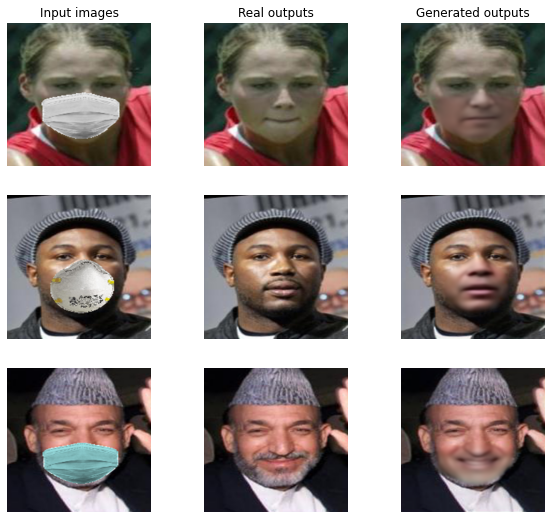

In [16]:
# Let's see the results on a random testing image unseen by the model before.
# Run this cell multiple times to see different results
n_examples = 3
input_imgs, true_output_imgs = dg.get_dataset_examples(n_examples, test_dataset=False)
f, axarr = plt.subplots(n_examples, 3, figsize=(10, n_examples * 3))
for i, img in enumerate(input_imgs):
    generated_output = trained_model.predict(img)
    axarr[i, 0].imshow(mpimg.imread(input_imgs[i]))
    axarr[i, 0].axis('off')
    axarr[i, 1].imshow(mpimg.imread(true_output_imgs[i]))
    axarr[i, 1].axis('off')
    axarr[i, 2].imshow(generated_output)
    axarr[i, 2].axis('off')

axarr[0, 0].set_title('Input images')
axarr[0, 1].set_title('Real outputs')
axarr[0, 2].set_title('Generated outputs')
print('Outputs generated on previously unseen data.')

In [17]:
download_data('http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz', "lfw-deepfunneled.tgz")
!mv  lfw-deepfunneled.tgz /tmp/

  0%|          | 0/108761145 [00:00<?, ?it/s]

In [18]:
download_from_drive("1cSDdwsCbshVPy5V9n7-BRfxxXzGIh_hH",'MLFW.zip')
!mv MLFW.zip /tmp/

CompletedProcess(args=['gdown', '--id', '1cSDdwsCbshVPy5V9n7-BRfxxXzGIh_hH', '--output', 'MLFW.zip'], returncode=0, stdout=b'', stderr=b"/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.\n  category=FutureWarning,\nDownloading...\nFrom: https://drive.google.com/uc?id=1cSDdwsCbshVPy5V9n7-BRfxxXzGIh_hH\nTo: /content/strv/MLFW.zip\n\r  0%|          | 0.00/275M [00:00<?, ?B/s]\r  5%|\xe2\x96\x8c         | 14.7M/275M [00:00<00:01, 147MB/s]\r 17%|\xe2\x96\x88\xe2\x96\x8b        | 47.7M/275M [00:00<00:00, 253MB/s]\r 29%|\xe2\x96\x88\xe2\x96\x88\xe2\x96\x8a       | 78.6M/275M [00:00<00:00, 278MB/s]\r 40%|\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88      | 111M/275M [00:00<00:00, 294MB/s] \r 52%|\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x88\xe2\x96\x8f    | 143M/275M [00:00<00:00, 303MB/s]\r 63%|\xe2\x96\x88\xe2\x96\x88\xe2\x96\x8

In [19]:
LFW_EXTRACTION_PATH = "/tmp/lfw"
LFW_EXTRACTION_COMMAND = "tar -xvf /tmp/lfw-deepfunneled.tgz -C /tmp/"
LFWD_EXTRACED_PATH = "/tmp/lfw-deepfunneled"
MLFW_EXTRACTION_PATH = "/tmp/mlfw"
MLFW_EXTRACTION_FILE = "/tmp/MLFW.zip"
MLFW_IMAGE_ORIGIN_PATH="/tmp/mlfw/aligned/*.jpg"
DRIVE_PATH='/content/gdrive'
DATASET_TRAIN_PATH='/tmp/dataset/train'
DATASET_TEST_PATH='/tmp/dataset/test'
DATASET_ROOT_PATH='/tmp/dataset'
MASKTHE_FACE_PATH="/content/MaskTheFace/"

In [20]:
def extract_lfw_mlfw(force=False):
  if(force):
    print("deleting ", LFW_EXTRACTION_PATH)
    if(os.path.isdir(LFW_EXTRACTION_PATH) == True):
      shutil.rmtree(LFW_EXTRACTION_PATH)
    print("deleting ", LFWD_EXTRACED_PATH)
    if(os.path.isdir(LFWD_EXTRACED_PATH) == True):
      shutil.rmtree(LFWD_EXTRACED_PATH)
    print("deleting ", MLFW_EXTRACTION_PATH)
    if(os.path.isdir(MLFW_EXTRACTION_PATH) == True):
      shutil.rmtree(MLFW_EXTRACTION_PATH)

  print("Extracing lfw and mlfw ..")
  if(os.path.isdir(LFW_EXTRACTION_PATH) == False):
    print("extracing lfw-deepfunneled..")
    # cmd = "tar -xvf gdrive/MyDrive/datasets/lfw.tar -C /tmp/"
    returned_value = os.system(LFW_EXTRACTION_COMMAND)
  if(os.path.isdir(LFWD_EXTRACED_PATH) == True):
    print("renaming to lfw..")
    os.rename(LFWD_EXTRACED_PATH, LFW_EXTRACTION_PATH)

  if(os.path.isdir(MLFW_EXTRACTION_PATH)== False):
    print("extracting mlfw..")
    zip_ref = zipfile.ZipFile(MLFW_EXTRACTION_FILE, 'r')
    zip_ref.extractall(MLFW_EXTRACTION_PATH)
    zip_ref.close()

In [21]:
extract_lfw_mlfw(force = True)

deleting  /tmp/lfw
deleting  /tmp/lfw-deepfunneled
deleting  /tmp/mlfw
Extracing lfw and mlfw ..
extracing lfw-deepfunneled..
renaming to lfw..
extracting mlfw..


In [22]:
! ls -l /tmp/

total 375020
-rw-------    1 root root       880 May 20 07:08 __autograph_generated_filemc1e6dn2.py
-rw-r--r--    1 root root      1166 May 20 05:36 dap_multiplexer.009cdca9caf2.root.log.INFO.20220520-053610.58
lrwxrwxrwx    1 root root        61 May 20 05:36 dap_multiplexer.INFO -> dap_multiplexer.009cdca9caf2.root.log.INFO.20220520-053610.58
srwxr-xr-x    1 root root         0 May 20 05:36 debugger_2g2y0k6w7l
drwx------    2 root root      4096 May 20 05:36 initgoogle_syslog_dir.0
drwxr-xr-x 5751 root root    204800 May 20 07:09 lfw
-rw-r--r--    1 root root 108761145 May 20 07:09 lfw-deepfunneled.tgz
drwxr-xr-x    4 root root      4096 May 20 07:09 mlfw
-rw-r--r--    1 root root 274972231 May 20 07:09 MLFW.zip
drwxr-xr-x    2 root root      4096 May 20 07:08 __pycache__
drwx------    2 root root      4096 May 20 06:50 pyright-1241-9RFOsAZrEXT3
drwx------    2 root root      4096 May 20 06:50 pyright-1241-exp35TdtjUJa
drwx------    2 root root      4096 May 20 05:37 pyright-139-PLhoo

In [23]:
# Get file list from lfw
lfw_files = []
for file in Path(LFW_EXTRACTION_PATH).rglob('*.jpg'):
  lfw_files.append(file)
mlfw_files = []
for file in Path(MLFW_EXTRACTION_PATH).rglob('*.jpg'):
  mlfw_files.append(file)
print(len(lfw_files))
print(len(mlfw_files))

13233
24000


In [24]:
def pick_images_lfw(max_samples):
  print("Picking images from lfw ..")
  lfw_images = []
  lfw_train = sorted(os.listdir(LFW_EXTRACTION_PATH))
  for directory in lfw_train:
    dir_path = LFW_EXTRACTION_PATH + "/" + directory
    no_of_files = len(os.listdir(dir_path)) 
    if(no_of_files >= max_samples ):
      lfw_images.append(directory)
  return lfw_images;

In [25]:
def pick_images_mlfw(max_samples):
  print("Picking images from mlfw ..")
  file_list = glob.glob(MLFW_IMAGE_ORIGIN_PATH)
  final_name_list = []
  for file in file_list:
      file_name = Path(file).name
      final_str = ""
      tokens = file_name.split("_")
      for token in tokens:
          if(token.isnumeric()):
              break;
          else:
              final_str += token
              final_str += "_"
      final_name_list.append(final_str)  
  df = pd.DataFrame(final_name_list)
  df.columns = ['name']
  new_df = df.groupby('name').filter(lambda x : (len(x) >= max_samples))
  mlfw_images = new_df.values.tolist()
  mlfw_images = [sub[0][ : -1] for sub in mlfw_images]
  return list(set(mlfw_images))

In [26]:
def create_common_dir_list(max_samples):
  print("create_common_dir_list ..")
  extract_lfw_mlfw();
  lfw_dir = pick_images_lfw(max_samples);
  mlfw_dir = pick_images_mlfw(max_samples)
  common_set = set(lfw_dir) & set(mlfw_dir)
  print("common_dir_list = " + str(len(common_set)))
  return list(common_set)

In [27]:
def pick_classes(no_of_classes, max_samples):
  print("Picking classes ..")
  final_list = []
  filtered_list =  create_common_dir_list(max_samples)
  print("filtered_list_length = " + str(len(filtered_list)))
  for i in range(0, no_of_classes):
      final_list.append(random.choice(filtered_list))
  return final_list

In [28]:
common_dir_list = create_common_dir_list(5)
len(common_dir_list)

create_common_dir_list ..
Extracing lfw and mlfw ..
Picking images from lfw ..
Picking images from mlfw ..
common_dir_list = 216


216

In [29]:
def create_train_test_set_from_lfw_mlfw(number_of_classes, max_samples):
  print("create_train_test_set_from_lfw_mlfw ..")
  final_class_list = pick_classes(number_of_classes, max_samples)
  print("length of final_class_list =>", len(final_class_list))
  if(os.path.isdir(DATASET_TRAIN_PATH) == True):
    shutil.rmtree(DATASET_TRAIN_PATH)
  if(os.path.isdir(DATASET_TEST_PATH) == True):
    shutil.rmtree(DATASET_TEST_PATH)
  if(os.path.isdir(DATASET_ROOT_PATH)  == False):
    os.mkdir(DATASET_ROOT_PATH)
  if(os.path.isdir(DATASET_TRAIN_PATH)== False):
    os.mkdir(DATASET_TRAIN_PATH)
  if(os.path.isdir(DATASET_TEST_PATH)== False):
    os.mkdir(DATASET_TEST_PATH)

  for dir in final_class_list:
    cmd_str = "cp -r " + LFW_EXTRACTION_PATH + "/" +dir + " " + DATASET_TRAIN_PATH
    # print(cmd_str)
    os.system(cmd_str)
  
  mlfw_jpg_list = glob.glob(MLFW_IMAGE_ORIGIN_PATH);
  # print
  # for path, subdirs, files in os.walk(MLFW_IMAGE_ORIGIN_PATH):
  #     print("path = ",path)
  #     for name in files:
  #         mlfw_jpg_list.append(os.path.join(path, name))

  # print("mlfw_jpg_list", mlfw_jpg_list)
  for dir in final_class_list:
    test_dir = DATASET_TEST_PATH + "/"+ dir
    # print(test_dir)
    if(os.path.isdir(test_dir)  == False):
      os.mkdir(DATASET_TEST_PATH + "/" +dir)
    name_list = [k for k in mlfw_jpg_list if dir in k]
    # print("name_list", name_list)
    for nme in name_list:
      copy_path = DATASET_TEST_PATH +  "/"+ dir + "/"
      # print(nme, copy_path)
      shutil.copy(nme, DATASET_TEST_PATH +  "/"+ dir + "/")

In [30]:
create_train_test_set_from_lfw_mlfw(50, 5)

create_train_test_set_from_lfw_mlfw ..
Picking classes ..
create_common_dir_list ..
Extracing lfw and mlfw ..
Picking images from lfw ..
Picking images from mlfw ..
common_dir_list = 216
filtered_list_length = 216
length of final_class_list => 50


In [107]:
def create_train_samples_from_main_dataset(no_of_classes, no_of_samples):
  new_dataset_name = "/tmp/mfr/dataset_"+str(no_of_classes) + "_" + str(no_of_samples)
  train_folder = new_dataset_name + "/" + "train"
  if(exists(new_dataset_name) == False):
    print("creating ", new_dataset_name)
    shutil.copytree('/tmp/dataset/', new_dataset_name)
  classes = 0
  train_dir_list = []
  for train_dir in os.listdir(train_folder):
    # for sample in os.listdir(train_dir):
    file_path = os.path.join(train_folder, train_dir)
    if(classes >= no_of_classes):
      shutil.rmtree(file_path)
      continue
    classes = classes + 1
    samples = 0
    train_dir_list.append(train_dir)
    for file_name in os.listdir(file_path):
      name = os.path.join(file_path, file_name)
      if(samples >= no_of_samples):
        os.remove(name)
        continue
      samples = samples + 1

  test_folder = new_dataset_name + "/" + "test"
  # print("train_dir_list", train_dir_list)
  for test_dir in os.listdir(test_folder):
    # for sample in os.listdir(train_dir):
    file_path = os.path.join(test_folder, test_dir)
    # print("test_dir = ", test_dir)
    # print("test_dir in train_dir_list ", test_dir in train_dir_list )
    if((test_dir in train_dir_list) == False):
      # print("deleting", file_path)
      shutil.rmtree(file_path)
      continue
  return new_dataset_name, train_folder, test_folder

In [88]:
# extract a single face from a given photograph
def process_and_save_image(image, filename, required_size=(256, 256)):
    # convert to array
    # image = Image.fromarray(image_pixels)
    # image = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    image = image.resize(required_size)
    # cv2.resize(image, required_size)
    # face_array = asarray(image)
    # cv2.imwrite(filename, image)
    # print('processed and saved file ===> ', filename)
    image.save(filename)

In [89]:
from mtcnn.mtcnn import MTCNN
from numpy import asarray
import cv2
 
# extract a single face from a given photograph
def process_face(filename, required_size=(256, 256)):
  # load image from file
  image = Image.open(filename)
  # convert to RGB, if needed
  # image = cv2.imread(filename)
  if(image.width != required_size[0]):
    # convert to array
    pixels = asarray(image)
    # create the detector, using default weights
    detector = MTCNN()
    # detect faces in the image
    results = detector.detect_faces(pixels)
    if(results):
      # extract the bounding box from the first face
      x1, y1, width, height = results[0]['box']
      # bug fix
      x1, y1 = abs(x1), abs(y1)
      x2, y2 = x1 + width, y1 + height
      # extract the face
      # image = image[y1:y2, x1:x2]
      facepixels = pixels[y1:y2, x1:x2]
      # resize pixels to the model size
      image = Image.fromarray(facepixels)
      # image = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      image = image.resize(required_size)
      # cv2.resize(image, required_size)
      # face_array = asarray(image)
      # cv2.imwrite(filename, image)
      # print('processed and saved file', filename)
      image.save(filename)

In [109]:
def augument_mask_data(train_folder):
  triplets = []
  print("Augumenting data ..")
  os.chdir(MASKTHE_FACE_PATH)
  # print("Current path=",os.getcwd())
  # os.system('pip install -r requirements.txt')
  f = [y for y in  Path(train_folder).rglob('*.jpg')] 
  print("total samples = >", len(f))
  for path in  Path(train_folder).rglob('*.jpg'):
    # print(path)
    normal_img_path = str(path)
    process_face(normal_img_path)
    subprocess.run(["python", "/content/MaskTheFace/mask_the_face.py",'--path', path, '--mask_type', 'N95', '--verbose', '--write_original_image'])
    files = Path(train_folder).rglob('*.jpg')
    recent_file =  max(files , key=os.path.getctime)
    process_face(recent_file)
    # print("recent file ==>", str(recent_file))
    # model = keras.models.load_model('/content/gdrive/MyDrive/mfr_test_repo/strv-ml-mask2face/mask2face_siva_trained/')
    # print((recent_file))
    masked_img_path  = str(recent_file)
    if(str(recent_file).find("unmask") == -1):
      image = Image.open(recent_file)
      # print(image.size)
      image = tf.expand_dims(img_to_array(image), axis=0)  
      # print(image.dim)
      # img_to_array
      # print("=========>", image.shape)
      generated_output = trained_model.predict((recent_file))
      # process_and_save_image(generated_output, recent_file)
      unmask_image_path = Path(recent_file)
      # print("stem ==>", unmask_image_path.stem)
      latest_unmasked_file = str(unmask_image_path.parent) +"/" +unmask_image_path.stem +"_unmask" + unmask_image_path.suffix
      # unmask_image_path.rename(Path(unmask_image_path.parent, latest_unmasked_file))
      # print("latest_unmasked_file", latest_unmasked_file)
      triplets.append([normal_img_path, masked_img_path, str(latest_unmasked_file)])
      # print(type(generated_output))
      # cv2_imshow(generated_output)
      process_and_save_image(generated_output, str(latest_unmasked_file))
      # print("-----------------------------------------------")
  return triplets
 

In [36]:
def plot_triplets(triplets):
  import matplotlib.image as mpimg
  images = []
  image_names = []

  for triplet in triplets:
      for i in triplet:
        images.append(mpimg.imread(i))
        image_names.append(i)

  plt.figure(figsize=(20,20))
  columns = 3
  for i, image in enumerate(images):
      ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
      ax.set_title(Path(image_names[i]).stem)
      plt.imshow(image)
      plt.xticks([])
      plt.yticks([])

In [37]:
def get_image_list_from_folder(path):
  final_list = []
  for path, subdirs, files in os.walk(path):
    for name in files:
        final_list.append(os.path.join(path, name))
  return sorted(final_list)

In [38]:
!pip install deepface

  Using cached opencv_python-4.5.5.64-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (60.5 MB)
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.4.0.44
    Uninstalling opencv-python-4.4.0.44:
      Successfully uninstalled opencv-python-4.4.0.44


In [70]:
from deepface import DeepFace
def get_embedding_list(path, model_name):
  print("get_embedding_list ...")
  img_list = get_image_list_from_folder(path)
  print("get_embedding_list",img_list)
  embedding_list = list()
  for file in img_list:
    embedding = DeepFace.represent(file, model_name = model_name, enforce_detection =False)
    embedding_list.append(embedding)
  final_name_list = []
  for file in img_list:
      file_name = Path(file).name
      final_str = ""
      tokens = file_name.split("_")
      for token in tokens:
          token = token.split(".",1)[0]
          if(token.isnumeric()):
              break;
          else:
              final_str += token
              final_str += "_"
      final_name_list.append(final_str) 
  final_name_list = [sub[ : -1] for sub in final_name_list]
  return embedding_list, final_name_list

In [66]:
def create_embeddings(model_name, number_of_classes, max_samples):
  print("creating embeddings ...")
  # create_train_test_set_from_lfw_mlfw(number_of_classes, max_samples)
  new_dataset_name, train_folder, test_folder = create_train_samples_from_main_dataset(number_of_classes, max_samples)
  triplets = augument_mask_data(train_folder)
  f = [y for y in  Path(train_folder).rglob('*.jpg')] 
  print("total samples after augumentation= >", len(f))
  # plot_triplets(triplets)
  # process_train_images()
  # plot_train_list()
  # plot_test_list()
  newTrainX, trainy = get_embedding_list(train_folder, model_name)
  newTrainX = asarray(newTrainX)
  newTestX, testy = get_embedding_list(test_folder, model_name)
  newTestX = asarray(newTestX)
  return newTrainX, trainy, newTestX, testy

In [41]:
def rearrange_dim(input):
  in_encoder = Normalizer(norm='l2')
  # nsamples, nx, ny = input.shape
  # input = input.reshape((nsamples,nx*ny))
  input = in_encoder.transform(input)
  return input

In [117]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def predict_accuracy(trainX, trainy, testX, testy):
  print("predicting accuracy ...")
  in_encoder = Normalizer(norm='l2')
  trainX = rearrange_dim(trainX)
  testX = rearrange_dim(testX)
  # nsamples, nx, ny = trainX.shape
  # trainX = trainX.reshape((nsamples,nx*ny))
  # trainX = in_encoder.transform(trainX)
  # nsamples, nx, ny = testX.shape
  # testX = testX.reshape((nsamples,nx*ny))
  # testX = in_encoder.transform(testX)
  # label encode targets
  out_encoder = LabelEncoder()
  out_encoder.fit(trainy)

  trainy = out_encoder.transform(trainy)
  testy = out_encoder.transform(testy)
  # trainy = rearrange_dim(trainy)
  # testy = rearrange_dim(testy)
  # fit model
  model = SVC(kernel='linear', probability=True)
  model.fit(trainX, trainy)
  # predict
  yhat_train = model.predict(trainX)
  yhat_test = model.predict(testX)
  # score
  score_train = accuracy_score(trainy, yhat_train)
  score_test = accuracy_score(testy, yhat_test)
  print("test score = >", score_test)
  # summarize
  #Generate the confusion matrix
  # cf_matrix = confusion_matrix(testy, yhat_test)
  # print(cf_matrix)
  # print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

  # ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

  # ax.set_title('Seaborn Confusion Matrix with labels\n\n');
  # ax.set_xlabel('\nPredicted Values')
  # ax.set_ylabel('Actual Values ');

  # ## Ticket labels - List must be in alphabetical order
  # ax.xaxis.set_ticklabels(['False','True'])
  # ax.yaxis.set_ticklabels(['False','True'])

  # disp = plot_confusion_matrix(model, testX, testy,
  #                                display_labels=class_names,
  #                                cmap=plt.cm.Blues)
  # plt.show()

  ## Display the visualization of the Confusion Matrix.
  # plt.show()
  return score_test

In [119]:
from deepface import DeepFace
from numpy import asarray
def run_fr_test( number_of_classes, max_classes, force_create=False):
  # models_list = ['Facenet', 'OpenFace', 'DeepFace', 'VGG-Face']
  models_list = ['Facenet']
  for model_name in models_list:
    trainX, trainy, testX, testy = create_embeddings(model_name,  number_of_classes, max_classes)
    print("Trying with model " + model_name)
    return predict_accuracy(trainX, trainy, testX, testy)

In [122]:
import pandas as pd
# class_list = ["2", "5", "10", "15", "20", "25", "30", "35", "40", "45", "50"]
# sample_list = ["1", "2", "3", "4", "5"]

class_list = ["2", "5"]
sample_list = ["1", "2"]
create_train_samples_from_main_dataset(50,5)
report_df = pd.DataFrame(columns = sample_list, 
                   index = class_list)  
shutil.rmtree('/tmp/mfr/')
result_list = []
for c in  class_list:
  result_list = []
  for s in sample_list:
    result = run_fr_test(int(c), int(s))
    print("result ===>", result)
    result_list.append(result)
  print("result_list ==============> ",result_list)
  report_df.loc[c] = result_list


creating  /tmp/mfr/dataset_50_5
creating embeddings ...
creating  /tmp/mfr/dataset_2_1
Augumenting data ..
total samples = > 2
(256, 256)
(256, 256)
total samples after augumentation= > 6
get_embedding_list ...
get_embedding_list ['/tmp/mfr/dataset_2_1/train/Jennifer_Aniston/Jennifer_Aniston_0005.jpg', '/tmp/mfr/dataset_2_1/train/Jennifer_Aniston/Jennifer_Aniston_0005_N95.jpg', '/tmp/mfr/dataset_2_1/train/Jennifer_Aniston/Jennifer_Aniston_0005_N95_unmask.jpg', '/tmp/mfr/dataset_2_1/train/Kofi_Annan/Kofi_Annan_0006.jpg', '/tmp/mfr/dataset_2_1/train/Kofi_Annan/Kofi_Annan_0006_N95.jpg', '/tmp/mfr/dataset_2_1/train/Kofi_Annan/Kofi_Annan_0006_N95_unmask.jpg']
get_embedding_list ...
get_embedding_list ['/tmp/mfr/dataset_2_1/test/Jennifer_Aniston/Jennifer_Aniston_0001_0000.jpg', '/tmp/mfr/dataset_2_1/test/Jennifer_Aniston/Jennifer_Aniston_0001_0001.jpg', '/tmp/mfr/dataset_2_1/test/Jennifer_Aniston/Jennifer_Aniston_0001_0002.jpg', '/tmp/mfr/dataset_2_1/test/Jennifer_Aniston/Jennifer_Aniston_00

In [123]:
 report_df.head()

,1,2
2,1.0,1.0
5,0.822222,0.822222
